In [1]:
# # ### Create a Dataset 
# from sklearn.datasets import load_wine
# import numpy as np
# import pandas as pd

# data = load_wine()
# # print(data.keys())

# # lbl = data['target_names']
# header = [a+str(n) for n,a in enumerate(np.repeat('A',data['data'].shape[1]))]
# df = pd.DataFrame(data['data'], columns=header)
# df.to_csv('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data.csv', index=False)
# df = df.iloc[:20,:]


In [2]:
import os
from dotenv import load_dotenv

load_dotenv('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/.env')

print(os.listdir('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/'))

raw_data_path = '/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data.csv'
annotations_path = '/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data.csv'

['wine_data_target.csv', 'fine_tune_data.jsonl', 'wine_data.csv', 'pca_result.png', 'sample_df.csv']


In [3]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.tools import tool

from langgraph.prebuilt import create_react_agent

from langchain_mcp_adapters.client import MultiServerMCPClient

import os
import sys

sys.path.append('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/src/')
from mytools import MyTools
from utils import Utils

load_dotenv('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/.env')

client = MultiServerMCPClient(
    {
        "mcp_tools": {
            
            "url": os.getenv('MCP_URL'),
            "transport": "sse"
        }
    }
)

prompt = ChatPromptTemplate([
    ('system','You are a statistics agent.\n\n'
    'INSTRUCTIONS:\n'
    '- Assist ONLY with statistics-related tasks, DO NOT provide visualizations, DO NOT do any thing else\n'
    '- After you are done with your tasks, respond to the supervisor directly\n'
    # '- Respond ONLY with the results of your work, do not include ANY other text.'),
    '- Respond ONLY with the results of your work.'),
    ('placeholder', '{messages}')  
])



mcp_tools = await client.get_tools()
mcp_tool = None

for obj in mcp_tools:
    if obj.name == 'google_search_tool':
        mcp_tool = obj

mytools = MyTools()
helper = Utils()

cust_tools = [mytools.correlation_tool, mytools.covariance_tool, mytools.anova_one_way, mytools.levene_test, mytools.normality_tool, mytools.calculate_PC, mcp_tool]

statistics_agent = create_react_agent(model=helper.openai_llm('gpt-4.1'), tools=cust_tools, prompt=prompt, name='statistics_agent')
# statistics_agent = create_react_agent(helper.aws_llm(helper.get_aws_llms()['Claude 3.5 Sonnet']), tools=cust_tools, prompt=prompt, name='statistics_agent')

In [4]:
# for tool in mcp_tools:
#     print(tool.name)

In [16]:
import asyncio

# query = 'Using google search provide an explination of What normality is'
query = f'Could you perform an normality check on {raw_data_path}?'

async for chunk in statistics_agent.astream({'messages':['user', query]}):
    helper.clean_print_msgs(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: statistics_agent

[{'type': 'text', 'text': "Certainly! I'd be happy to perform a normality check on the data in the file you specified. For this task, we'll use the normality_tool function. Let me run that for you now."}, {'type': 'tool_use', 'name': 'normality_tool', 'input': {'path': '/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/sample_df.csv'}, 'id': 'tooluse_yY2tpAjLRUagrd0qyPtREA'}]
Tool Calls:
  normality_tool (tooluse_yY2tpAjLRUagrd0qyPtREA)
 Call ID: tooluse_yY2tpAjLRUagrd0qyPtREA
  Args:
    path: /home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/sample_df.csv
Update from node tools:


================================= Tool Message =================================
Name: normality_tool

Column A14 is not normally distributed, and not recommended to include in ANOVA analysis
Update from node agent:


===========================

In [5]:
from langchain_core.prompts import ChatPromptTemplate 

from langgraph.prebuilt import create_react_agent

prompt = ChatPromptTemplate([
    ('system','You are a visualization agent.\n\n'
    'INSTRUCTIONS:\n'
    '- Assist ONLY with visualization-related tasks\n'
    '- After you are done with your tasks, respond to the supervisor directly\n'
    # '- Respond ONLY with the results of your work, do not include ANY other text.'),
    '- Respond ONLY with the results of your work.'),
    ('placeholder', '{messages}')  
])


visualization_agent = create_react_agent(model=helper.openai_llm('gpt-4.1'), tools=[mytools.gen_plot], prompt=prompt, name='visualization_agent')
# visualization_agent = create_react_agent(helper.aws_llm('us.'+helper.get_aws_llms()['Claude 3.5 Sonnet']), tools=[mytools.gen_plot], prompt=prompt, name='visualization_agent')

Update from node agent:


================================== Ai Message ==================================
Name: visualization_agent

[{'type': 'text', 'text': "Certainly! I'll generate a line plot with the specifications you've provided using the available `gen_plot` function. Here's the function call to create the plot:"}, {'type': 'tool_use', 'name': 'gen_plot', 'input': {'plot_type': 'line', 'title': 'Sales Over Time', 'x': [1, 2, 3, 4, 5], 'y': [10, 20, 15, 30, 25]}, 'id': 'tooluse_Nz70hFZYRCyzg2lPCjM9dw'}]
Tool Calls:
  gen_plot (tooluse_Nz70hFZYRCyzg2lPCjM9dw)
 Call ID: tooluse_Nz70hFZYRCyzg2lPCjM9dw
  Args:
    plot_type: line
    title: Sales Over Time
    x: [1, 2, 3, 4, 5]
    y: [10, 20, 15, 30, 25]
Update from node tools:


================================= Tool Message =================================
Name: gen_plot

image created
Update from node agent:


================================== Ai Message ==================================
Name: visualization_agent

I've gen

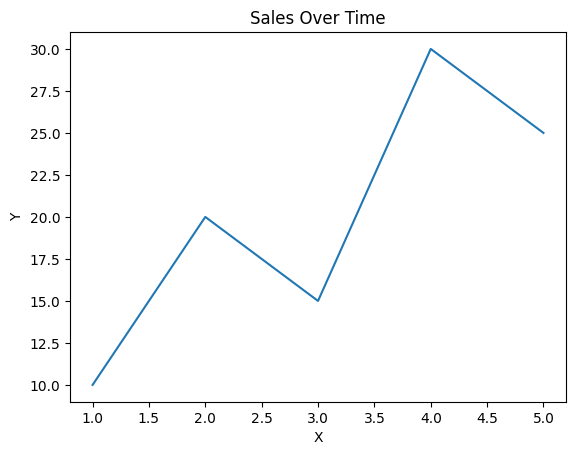

In [18]:
query = 'Generate a line plot with the title "Sales Over Time. The x-axis should be [1, 2, 3, 4, 5] representing months, and the y-axis should be [10, 20, 15, 30, 25] representing sales in thousands.'

for chunk in visualization_agent.stream({'messages':['user', query]}):
    helper.clean_print_msgs(chunk)

In [6]:
from typing import Annotated

from langchain_core.tools import tool, InjectedToolCallId

from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def init_handoff_tool(*, agent_name: str, description: str | None=None):
    name = f'transfer_to_{agent_name}'
    description = description or f'Ask {agent_name} for help' 

    @tool(name, description=description)
    def handoff_tool(state: Annotated[MessagesState, InjectedState], tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
        tool_message = {
            'role':'tool',
            'content': f'Successfully transferred to {agent_name}',
            'name': name,
            'tool_call_id': tool_call_id}

        # state['messages'].append(tool_message)
        
        return Command(goto=agent_name, update={**state, 'messages':state['messages']+[tool_message]}, graph=Command.PARENT)
    return handoff_tool

    
assign_to_statistics_agent = init_handoff_tool(agent_name='statistics_agent', description='Assign task to a statistics agent.')
assign_to_visualization_agent = init_handoff_tool(agent_name='visualization_agent', description='Assign task to a visualization agent.')


In [7]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver


from langchain_aws import ChatBedrockConverse

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate([
    ('system','You are a supervisor managing two agents\n\n'
    '- a statistics agent. Assign statistics related tasks to this agent\n'
    '- a visualization agent. Assign visualization related tasks to this agent\n'
    # 'Assign work to one agent at a time, do not call agents in parallel. \n'
    'Assign work to the agents. \n'
    'Do not do any work yourself. \n'
    'Summarise the work of each agent that produced a result. \n'
    'If there is no response from one of your agents provide an explination as to why.'),    
    ('placeholder', '{messages}')  
])

memory = MemorySaver()
config = {'configurable': {'thread_id': 'test_thread'}}

supervisor_agent = create_react_agent(model=helper.aws_llm('us.'+helper.get_aws_llms()['Claude Sonnet 4']), tools=[assign_to_visualization_agent, assign_to_statistics_agent], prompt=prompt, checkpointer=memory, name='supervisor')

# supervisor_agent = create_react_agent(model=helper.openai_llm('gpt-4.1'), tools=[assign_to_visualization_agent, assign_to_statistics_agent], prompt=prompt, checkpointer=memory, name='supervisor')

In [8]:
supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent)
    .add_node(statistics_agent)
    .add_node(visualization_agent)
    .add_edge(START, 'supervisor')
    .add_edge('statistics_agent', 'supervisor')
    .add_edge('visualization_agent', 'supervisor')
    .compile()
)

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_statistics_agent

Successfully transferred to statistics_agent
Update from node statistics_agent:


================================== Ai Message ==================================
Name: statistics_agent

The principal components of all the columns in the provided wine_data.csv file have been calculated. If you need further statistical analysis or interpretation of these principal components, please specify. 

Note: I am unable to provide a scatter plot visualization as my capabilities are limited to statistics-related tasks only.
Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_visualization_agent

Successfully transferred to visualization_agent
Update from node visualization_agent:


================================== Ai Message ==================================
Name: visuali

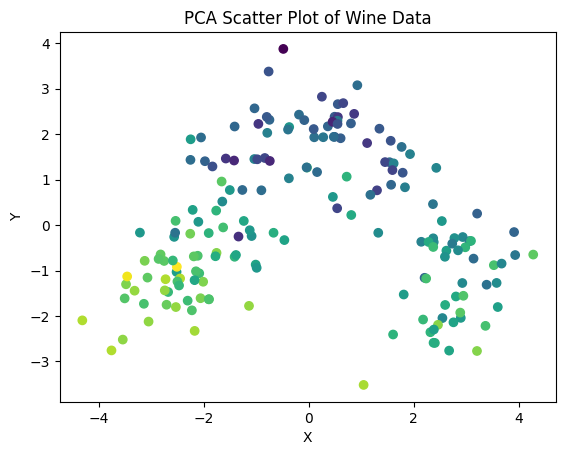

In [9]:
query = f'Calculate the principal components of all the columns in {raw_data_path} and could you provide a scatter plot of the results using {annotations_path} as labels for the data'

for chunk in supervisor.stream({'messages':[{'role':'user','content': [{'type': 'text', 'text':query}]}]}):
    helper.clean_print_msgs(chunk, last_message=True)